Vikas K. Sinha
Data620
Project 1

 ### Patent Citation Network

 This dataset is from the Stanford Network Analysis Project. It consists of patent citation instances
 for utility patents filed with the US Patent Office.
 
 The following description is copied from 
 http://snap.stanford.edu/data/cit-Patents.html
 
    The data set spans 37 years (January 1, 1963 to December 30, 1999), and includes
    all the utility patents granted during that period, totaling 3,923,922 patents. The
    citation graph includes all citations made by patents granted between 1975 and 1999,
    totaling 16,522,438 citations. For the patents dataset there are 1,803,511 nodes for
    which we have no information about their citations (we only have the in-links).

## Objective


In this project, we compare characteristics of the base citation network, and the network of patents that have 
two or more citations.

In [39]:
import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx
from networkx import algorithms
import collections
from neo4j import GraphDatabase
import random

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

### Read text file

The file contains 16,518,952 lines. In this project we use only 100000 lines of the file.

In [40]:
datafile = "cit-Patents2.txt"
n = 16518948        # number of records in file
s = 400000          # desired sample size

# Random sample of given size
skip = sorted(random.sample(range(n), n-s))
edgelist = pd.read_csv(datafile, skiprows=skip,
                       header=None, delim_whitespace=True,
                       names=["FromNodeId", "ToNodeId"])

In [41]:
edgelist.shape
edgelist.head()

(400000, 2)

,FromNodeId,ToNodeId
0,3858247,1600859
1,3858248,2875449
2,3858254,3736601
3,3858266,2423658
4,3858271,3345675


In [42]:
# Create empty Directed Graph (DiGraph)
basegraph = nx.DiGraph()

# Add edges.
for i, elrow in edgelist.iterrows():
    basegraph.add_edge(elrow[0], elrow[1])

As seen in the prior table, each line of the citation is an edge from a source patent to another patent that is cited by it.

In [45]:
print("Total number of nodes: {0}" .format(basegraph.number_of_nodes()))
print("Total number of edges: {0}" .format(basegraph.number_of_edges()))

Total number of nodes: 653828
Total number of edges: 400000


In [46]:
# Iterate over all edges, select those whose nodes have two or more edges
def trim_degrees(g, degree):
    g2 = g.copy()
    d = nx.degree(g2)
    for n in g.nodes():
        if d[n] <= degree:
            g2.remove_node(n)
    return g2

In [47]:
# Build graph of patents that have been cited 1 or more times.
graph2 = trim_degrees(basegraph, 1)
graph2.number_of_nodes()
graph2.number_of_edges()

89435

38886

### Clustering coefficient

Clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together.
We compute clustering coefficients for the main graph and the two graphs for high and low ratings.

In [48]:
ac1 = nx.average_clustering(basegraph)
ac2 = nx.average_clustering(graph2)

In [49]:
print("Average clustering for all Patents: {0:10.2}" .format(ac1))
print("Average clustering for patents with 1 or more citations: {0:10.2}" .format(ac2))

Average clustering for all Patents:    0.00017
Average clustering for patents with 1 or more citations:     0.0016


## Eigenvector Centrality
We compare eigenvector centrality for the main network of patents, as well as the network of those patents that have been cited one or more times.
To show eigenvector centrality for each graph, we select the top 100 nodes (according to eigenvector centrality values) for each.

### Compute eigenvector centrality for top 100 nodes in each graph

In [50]:
def top_eigenvector_centrality_nodes(graph, count=100):
    ec = nx.eigenvector_centrality(graph)
    all_nodes = [(node, ec[node]) for node in ec]
    top_nodes = sorted(all_nodes, key = lambda x : x[1], reverse=True)
    top_nodes = top_nodes[0:count]
    return top_nodes

In [51]:
t1 = top_eigenvector_centrality_nodes(basegraph)
t2 = top_eigenvector_centrality_nodes(graph2)

t1 = [elem[0] for elem in t1]
t2 = [elem[0] for elem in t2]

G1 = basegraph.subgraph(t1)
G2 = basegraph.subgraph(t2)

tec_base = nx.eigenvector_centrality(G1, max_iter=4000)
tec_graph2 = nx.eigenvector_centrality(G2, max_iter=4000)

### Display histograms of eigenvector centralities for the two graphs

* main citation graph 
* subgraph of patents with degree >1

In [52]:
tec_base = [(k,v) for k,v in tec_base.items()]
tec_base = sorted(tec_base, key = lambda x : x[1], reverse=True)
tec_base_eigen = [t[1] for t in tec_base]

tec_graph2 = [(k,v) for k,v in tec_graph2.items()]
tec_graph2 = sorted(tec_graph2, key = lambda x : x[1], reverse=True)
tec_graph2_eigen = [t[1] for t in tec_graph2]

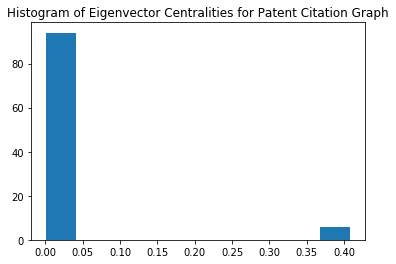

In [53]:
t1 = plt.title("Histogram of Eigenvector Centralities for Patent Citation Graph")
h1 = plt.hist(tec_base_eigen)

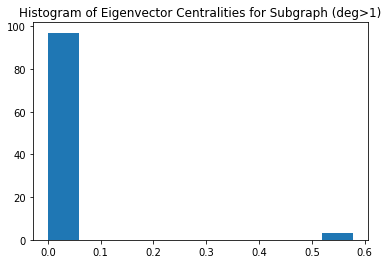

In [54]:
t2 = plt.title("Histogram of Eigenvector Centralities for Subgraph (deg>1)")
h2 = plt.hist(tec_graph2_eigen)

## Degree Centrality

We compare Degree centrality for the main network of patents, as well as the network of
those patents that have been cited one or more times.

In [55]:
def top_degree_centrality_nodes(graph, count=100):
    ec = nx.degree_centrality(graph)
    all_nodes = [(node, ec[node]) for node in ec]
    top_nodes = sorted(all_nodes, key = lambda x : x[1], reverse=True)
    top_nodes = top_nodes[0:count]
    return top_nodes

In [56]:
t1 = top_degree_centrality_nodes(basegraph)
t2 = top_degree_centrality_nodes(graph2)

t1 = [elem[0] for elem in t1]
t2 = [elem[0] for elem in t2]

G1 = basegraph.subgraph(t1)
G2 = basegraph.subgraph(t2)

degc_base = nx.degree_centrality(G1)
degc_graph2 = nx.degree_centrality(G2)

degc_base = [(k,v) for k,v in degc_base.items()]
degc_base = sorted(degc_base, key = lambda x : x[1], reverse=True)
degc_base_vals = [t[1] for t in degc_base]

degc_graph2 = [(k,v) for k,v in degc_graph2.items()]
degc_graph2 = sorted(degc_graph2, key = lambda x : x[1], reverse=True)
degc_graph2_vals = [t[1] for t in degc_graph2]

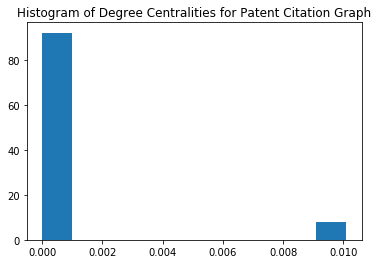

In [57]:
t1 = plt.title("Histogram of Degree Centralities for Patent Citation Graph")
h1 = plt.hist(degc_base_vals)

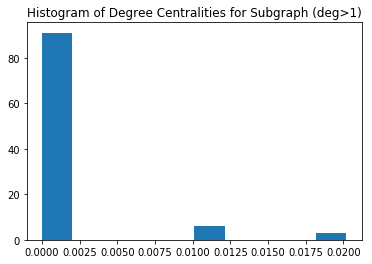

In [58]:
t2 = plt.title("Histogram of Degree Centralities for Subgraph (deg>1)")
h2 = plt.hist(degc_graph2_vals)

### References

1. https://networkx.github.io/documentation/stable/reference/index.html
2. Tsvetovat, Maksim and Kouznetsov, Alexander (2011). Social Network Analysis for Startups. O'Reilly Media, Inc."
3. Patent Citation Network. http://snap.stanford.edu/data/cit-Patents.html
